In [237]:
from datetime import datetime, timedelta
# import utils
# import pytz
import requests
import numpy as np
import pandas as pd
import datetime
import joblib
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [218]:
!pip install --upgrade scikit-learn

In [238]:
api_key = "080275865c09c4113e944693377074bf"

In [220]:
import datetime

def fetch_five_day_forecast(city, api_key):
    api_url = f"https://api.openweathermap.org/data/2.5/forecast?q={city}&units=imperial&appid={api_key}"
    response = requests.get(api_url)
    data = response.json()
    forecast_data = []

    if 'list' in data:
        for i in range(4, len(data['list']), 8):
            daily_data = data['list'][i]
            date = datetime.datetime.utcfromtimestamp(daily_data['dt']).strftime('%Y-%m-%d')
            forecast_data.append({
                "City": city,
                "Date": date,
                "Temperature": daily_data['main']['temp'],
                "Feels Like": daily_data['main']['feels_like'],
                "Description": daily_data['weather'][0]['description'],
                "Humidity": daily_data['main']['humidity'],
                "Wind Speed": daily_data['wind']['speed'],
                "Cloudiness": daily_data['clouds']['all'],
                "Pressure": daily_data['main']['pressure']
            })

    return forecast_data

top_cities_canada = [
    "Toronto", "Montreal", "Vancouver", "Calgary", "Edmonton",
    "Ottawa", "Winnipeg", "Quebec City", "Hamilton", "Kitchener",
    "London", "Victoria", "Halifax", "Oshawa", "Windsor",
    "Saskatoon", "Regina", "St. John's", "Barrie", "Sherbrooke"
]


In [239]:
# Fetching forecast data for all cities
forecast_data_all_cities = []
for city in top_cities_canada:
    forecast_data_city = fetch_five_day_forecast(city, api_key)
    forecast_data_all_cities.extend(forecast_data_city)


# Creating DataFrame

df = pd.DataFrame(forecast_data_all_cities)
df

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-18,55.35,55.24,overcast clouds,99,3.42,92,1012
1,Toronto,2024-05-19,55.92,55.78,broken clouds,97,2.91,66,1015
2,Toronto,2024-05-20,60.24,59.77,broken clouds,81,0.96,60,1016
3,Toronto,2024-05-21,60.53,60.28,overcast clouds,85,2.75,100,1011
4,Toronto,2024-05-22,63.84,64.26,broken clouds,92,4.79,72,1007
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-18,54.16,53.74,overcast clouds,95,3.20,100,1016
96,Sherbrooke,2024-05-19,48.65,47.95,clear sky,96,3.22,7,1017
97,Sherbrooke,2024-05-20,51.89,51.30,few clouds,96,3.83,11,1017
98,Sherbrooke,2024-05-21,58.19,58.23,overcast clouds,96,3.83,93,1013


In [240]:
print("Unique city names before encoding:")
print(df['City'].unique())

Unique city names before encoding:
['Toronto' 'Montreal' 'Vancouver' 'Calgary' 'Edmonton' 'Ottawa' 'Winnipeg'
 'Quebec City' 'Hamilton' 'Kitchener' 'London' 'Victoria' 'Halifax'
 'Oshawa' 'Windsor' 'Saskatoon' 'Regina' "St. John's" 'Barrie'
 'Sherbrooke']


In [241]:

print(df.dtypes)
print(end='\n')
print(df.isna().sum())
print(end='\n')
print(df.columns)


City            object
Date            object
Temperature    float64
Feels Like     float64
Description     object
Humidity         int64
Wind Speed     float64
Cloudiness       int64
Pressure         int64
dtype: object

City           0
Date           0
Temperature    0
Feels Like     0
Description    0
Humidity       0
Wind Speed     0
Cloudiness     0
Pressure       0
dtype: int64

Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure'],
      dtype='object')


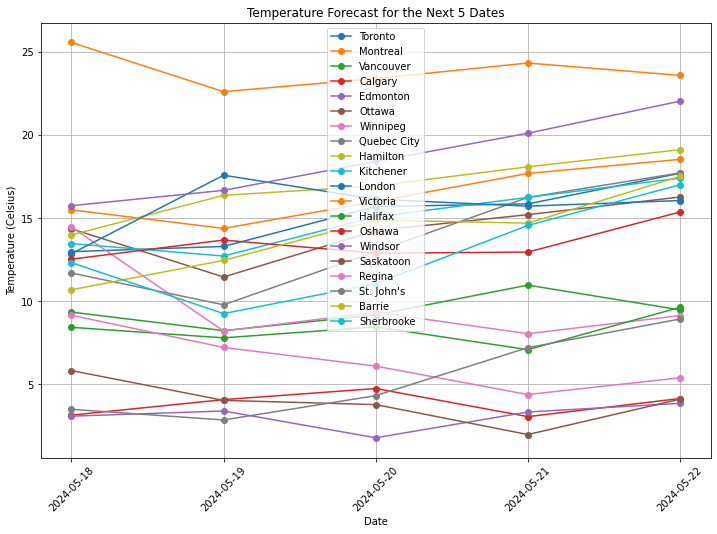

In [242]:
def plot_weather_forecast(df):
    plt.figure(figsize=(12, 8))

    for city in df['City'].unique():
        city_data = df[df['City'] == city].sort_values(by='Date').head(5)
        temperatures_celsius = [(temp - 32) * 5/9 for temp in city_data['Temperature']]

        plt.plot(city_data['Date'], temperatures_celsius,
                 marker='o', label=city)

    plt.title("Temperature Forecast for the Next 5 Dates")
    plt.xlabel('Date')
    plt.ylabel('Temperature (Celsius)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.show()


# Plot weather forecast for each city
plot_weather_forecast(df)




In [243]:
# Saving DataFrame to CSV file
# df['Date'] = pd.to_datetime(df['Date'])
df.to_csv('weather_forecast.csv', index=False)

# Loading CSV file back into a DataFrame
df_from_csv = pd.read_csv('weather_forecast.csv')
df_from_csv

,City,Date,Temperature,Feels Like,Description,Humidity,Wind Speed,Cloudiness,Pressure
0,Toronto,2024-05-18,55.35,55.24,overcast clouds,99,3.42,92,1012
1,Toronto,2024-05-19,55.92,55.78,broken clouds,97,2.91,66,1015
2,Toronto,2024-05-20,60.24,59.77,broken clouds,81,0.96,60,1016
3,Toronto,2024-05-21,60.53,60.28,overcast clouds,85,2.75,100,1011
4,Toronto,2024-05-22,63.84,64.26,broken clouds,92,4.79,72,1007
...,...,...,...,...,...,...,...,...,...
95,Sherbrooke,2024-05-18,54.16,53.74,overcast clouds,95,3.20,100,1016
96,Sherbrooke,2024-05-19,48.65,47.95,clear sky,96,3.22,7,1017
97,Sherbrooke,2024-05-20,51.89,51.30,few clouds,96,3.83,11,1017
98,Sherbrooke,2024-05-21,58.19,58.23,overcast clouds,96,3.83,93,1013


In [245]:
print("Unique city names before encoding:")
print(df['City'].unique())
print(df.columns)
# Label encode the 'City' column using .loc
label_encoder_city = LabelEncoder()
label_encoder_desc = LabelEncoder()

df['Description_encoded'] = label_encoder_desc.fit_transform(df['Description'])
df['City'] = label_encoder_city.fit_transform(df['City'])
df['Date'] = pd.to_datetime(df['Date'])
df['Date_encoded'] = df['Date'].map(lambda x: x.toordinal())

# Define feature names
feature_names = ['Temperature', 'Humidity', 'Wind Speed', 'Cloudiness', 'Pressure']

# Set feature names for X
X = df[feature_names]

y = df['Description_encoded'].values.reshape(-1, 1)


# Print unique city names after encoding
print("Unique city names after encoding:")
print(label_encoder_city.classes_)


Unique city names before encoding:
[15  7 16  1  2  9 19 10  4  5  6 17  3  8 18 12 11 14  0 13]
Index(['City', 'Date', 'Temperature', 'Feels Like', 'Description', 'Humidity',
       'Wind Speed', 'Cloudiness', 'Pressure', 'Description_encoded',
       'Date_encoded'],
      dtype='object')
Unique city names after encoding:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [246]:

# Model Training


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the logistic regression model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)

# Train the random forest model
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)


/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

RandomForestClassifier()

In [247]:
# Make predictions using logistic regression and random forest models
logistic_predictions = logistic_model.predict(X_test)
random_forest_predictions = random_forest_model.predict(X_test)

# Add predictions to the DataFrame
X_test['Logistic_Prediction'] = logistic_predictions
X_test['Random_Forest_Prediction'] = random_forest_predictions
X_test['Actual_Description'] = label_encoder_desc.inverse_transform(y_test)

# Save the DataFrame to a new CSV file
X_test.to_csv('predictions_with_actual.csv', index=False)
X_test.to_csv


/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<bound method NDFrame.to_csv of     Temperature  Humidity  Wind Speed  Cloudiness  Pressure  \
83        39.88        82        9.19          97      1017   
53        60.28        55        3.87          48      1010   
70        60.33        94        2.51           0      1011   
45        56.23        95        3.69         100      1012   
44        66.40        89        9.06          94      1009   
39        63.88        99        4.45          96      1008   
22        35.20        98       10.92         100      1020   
80        48.47        70       13.35          99      1000   
10        48.81        79        8.03         100      1017   
0         55.35        99        3.42          92      1012   
18        37.49        95        6.55          98      1017   
30        58.03        95        8.32         100       995   
73        68.18        78        6.71          98      1010   
33        46.47        78        5.21          65      1013   
90        51.22        

In [248]:
import pandas as pd

# Load the old weather forecast data
df_old = pd.read_csv('weather_forecast.csv')

# Load the new predictions data
df_new = pd.read_csv('predictions_with_actual.csv')

# Rename columns in the new DataFrame to match the old DataFrame
df_new.rename(columns={'Logistic_Prediction': 'Description'}, inplace=True)

# Merge the old and new DataFrames based on their index
df_merged = pd.merge(df_old, df_new, left_index=True, right_index=True, suffixes=('_old', '_new'))
# Rename columns in the merged DataFrame
df_merged.rename(columns={
    'Temperature': 'Temperature_old',
    'Humidity': 'Humidity_old',
    'Wind Speed': 'Wind Speed_old',
    'Cloudiness': 'Cloudiness_old',
    'Pressure': 'Pressure_old'
}, inplace=True)
# Save the merged DataFrame to a new CSV file
df_merged.to_csv('merged_data.csv', index=False)

df_merged.to_csv

<bound method NDFrame.to_csv of          City        Date  Temperature_old  Feels Like   Description_old  \
0     Toronto  2024-05-18            55.35       55.24   overcast clouds   
1     Toronto  2024-05-19            55.92       55.78     broken clouds   
2     Toronto  2024-05-20            60.24       59.77     broken clouds   
3     Toronto  2024-05-21            60.53       60.28   overcast clouds   
4     Toronto  2024-05-22            63.84       64.26     broken clouds   
5    Montreal  2024-05-18            59.88       59.52   overcast clouds   
6    Montreal  2024-05-19            57.87       57.49         clear sky   
7    Montreal  2024-05-20            60.78       60.37  scattered clouds   
8    Montreal  2024-05-21            63.82       64.33   overcast clouds   
9    Montreal  2024-05-22            65.35       65.77   overcast clouds   
10  Vancouver  2024-05-18            48.81       45.30        light rain   
11  Vancouver  2024-05-19            46.80       46.80  

In [229]:
# Print the shape of input data during training
print("Training Data Shape (X):", X.shape)
print("Training Data Shape (y):", y.shape)
print("Training Data Columns:", X.columns)

Training Data Shape (X): (100, 5)
Training Data Shape (y): (100, 1)
Training Data Columns: Index(['Temperature', 'Humidity', 'Wind Speed', 'Cloudiness', 'Pressure'], dtype='object')


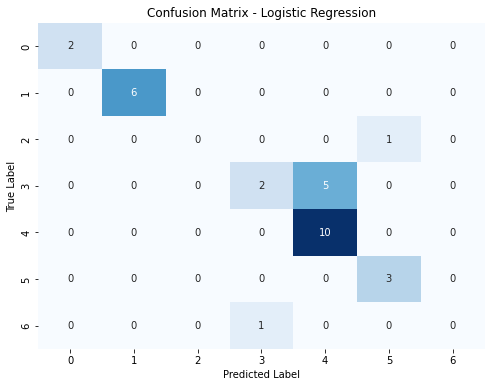

In [249]:
# Make predictions using logistic regression model
logistic_predictions = logistic_model.predict(X_test[feature_names])

# Compute confusion matrix for logistic regression model
logistic_conf_matrix = confusion_matrix(y_test, logistic_predictions)

# Plot confusion matrix for logistic regression model
plt.figure(figsize=(8, 6))
sns.heatmap(logistic_conf_matrix, annot=True,
            cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

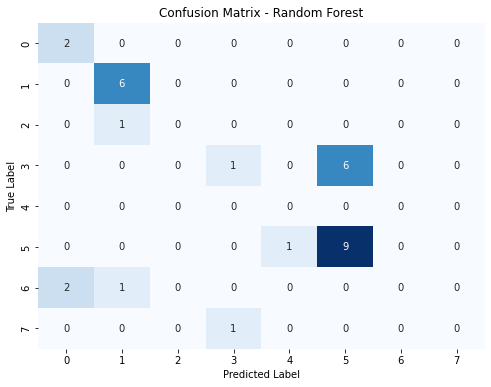

In [250]:
# Make predictions using random forest model
forest_predictions = random_forest_model.predict(X_test[feature_names])

# Compute confusion matrix for random forest model
forest_conf_matrix = confusion_matrix(y_test, forest_predictions)

# Plot confusion matrix for random forest model
plt.figure(figsize=(8, 6))
sns.heatmap(forest_conf_matrix, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [251]:
# # Model Saving
# joblib.dump(logistic_model, 'logistic_regression_weather_model.joblib')
# joblib.dump(random_forest_model, 'random_forest_weather_model.joblib')

import pickle

# Saving the models
with open('logistic_regression_weather_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

with open('random_forest_weather_model.pkl', 'wb') as f:
    pickle.dump(random_forest_model, f)


['random_forest_weather_model.joblib']

In [252]:
# from joblib import load

# # Load logistic regression model
# logistic_model = load('logistic_regression_weather_model.joblib')

# # Load random forest model
# random_forest_model = load('random_forest_weather_model.joblib')
import pickle

# Loading the models
with open('logistic_regression_weather_model.pkl', 'rb') as f:
    logistic_model = pickle.load(f)

with open('random_forest_weather_model.pkl', 'rb') as f:
    random_forest_model = pickle.load(f)

In [253]:
# Make predictions using logistic regression model
logistic_predictions = logistic_model.predict(X_test[feature_names])

# Generate classification report for logistic regression model
print("Logistic Regression Model Classification Report:")
print(classification_report(y_test, logistic_predictions))

# Make predictions using random forest model
random_forest_predictions = random_forest_model.predict(X_test[feature_names])

# Generate classification report for random forest model
print("Random Forest Model Classification Report:")
print(classification_report(y_test, random_forest_predictions))

Logistic Regression Model Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         6
           2       0.00      0.00      0.00         1
           3       0.67      0.29      0.40         7
           5       0.67      1.00      0.80        10
           6       0.75      1.00      0.86         3
           7       0.00      0.00      0.00         1

    accuracy                           0.77        30
   macro avg       0.58      0.61      0.58        30
weighted avg       0.72      0.77      0.71        30

Random Forest Model Classification Report:
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         2
           1       0.75      1.00      0.86         6
           2       0.00      0.00      0.00         1
           3       0.50      0.14      0.22         7
           4       0.00      0.00      0

/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/diptir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/

In [306]:
# Function to convert temperature from Fahrenheit to Celsius


def fahrenheit_to_celsius(fahrenheit):
    return (fahrenheit - 32) * 5/9

In [24]:

def create_rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape),
        Dense(32, activation='relu'),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model


# Prepare data for RNN
# Reshape input data for RNN
X_rnn = X.values.reshape((X.shape[0], 1, X.shape[1]))
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(
    X_rnn, y, test_size=0.3, random_state=42)

# Create and train the RNN model
rnn_model = create_rnn_model(input_shape=(
    X_train_rnn.shape[1], X_train_rnn.shape[2]))
early_stopping = EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True)
history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=100,
                        batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the RNN model
train_loss = rnn_model.evaluate(X_train_rnn, y_train_rnn)
val_loss = rnn_model.evaluate(X_test_rnn, y_test_rnn)
print(f"Training Loss: {train_loss}")
print(f"Validation Loss: {val_loss}")

Epoch 1/100
2/2 [==============================] - 3s 667ms/step - loss: 21.0625 - accuracy: 0.1071 - val_loss: 19.1905 - val_accuracy: 0.1429
Epoch 2/100
2/2 [==============================] - 0s 67ms/step - loss: 20.3439 - accuracy: 0.1071 - val_loss: 18.5120 - val_accuracy: 0.1429
Epoch 3/100
2/2 [==============================] - 0s 85ms/step - loss: 19.6390 - accuracy: 0.1071 - val_loss: 17.8463 - val_accuracy: 0.1429
Epoch 4/100
2/2 [==============================] - 0s 64ms/step - loss: 18.9672 - accuracy: 0.0893 - val_loss: 17.2339 - val_accuracy: 0.0000e+00
Epoch 5/100
2/2 [==============================] - 0s 68ms/step - loss: 18.3403 - accuracy: 0.0714 - val_loss: 16.6395 - val_accuracy: 0.0000e+00
Epoch 6/100
2/2 [==============================] - 0s 68ms/step - loss: 17.7108 - accuracy: 0.0714 - val_loss: 16.0573 - val_accuracy: 0.0000e+00
Epoch 7/100
2/2 [==============================] - 0s 66ms/step - loss: 17.1107 - accuracy: 0.0714 - val_loss: 15.4857 - val_accuracy: 

In [25]:
# During Evaluation Phase
train_predictions = rnn_model.predict(X_train_rnn)
train_mse = mean_squared_error(y_train_rnn, train_predictions)
print(f"Training MSE: {train_mse}")

val_predictions = rnn_model.predict(X_test_rnn)
val_mse = mean_squared_error(y_test_rnn, val_predictions)
print(f"Validation MSE: {val_mse}")


3/3 [==============================] - 0s 6ms/step
Training MSE: 4.964785729240871
1/1 [==============================] - 0s 26ms/step
Validation MSE: 6.1515438614488325


In [26]:
#Check data quality
print(df.info())
print(df.describe())

# Calculate accuracy for training set
# print("Train predictions shape:", train_predictions.shape)
# print("y_train_rnn shape:", y_train_rnn.shape)
train_predictions_flat = train_predictions.flatten()
val_predictions_flat = val_predictions.flatten()
y_test_rnn_flat = y_test_rnn.flatten()


threshold = 2  # Define the threshold for accuracy
train_accuracy = np.mean(
    np.abs(train_predictions_flat - y_train_rnn) <= threshold)

print(f"Training Accuracy: {train_accuracy}")

# Calculate accuracy for test set
val_accuracy = np.mean(
    np.abs(val_predictions_flat - y_test_rnn_flat) <= threshold)

print(f"Validation Accuracy: {val_accuracy}")




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   City                 100 non-null    int64         
 1   Date                 100 non-null    datetime64[ns]
 2   Temperature          100 non-null    float64       
 3   Feels Like           100 non-null    float64       
 4   Description          100 non-null    object        
 5   Humidity             100 non-null    int64         
 6   Wind Speed           100 non-null    float64       
 7   Cloudiness           100 non-null    int64         
 8   Pressure             100 non-null    int64         
 9   Description_encoded  100 non-null    int64         
 10  Date_encoded         100 non-null    int64         
dtypes: datetime64[ns](1), float64(3), int64(6), object(1)
memory usage: 8.7+ KB
None
             City                 Date  Temperature  Feels Like    Hu

1/1 [==============================] - 0s 35ms/step


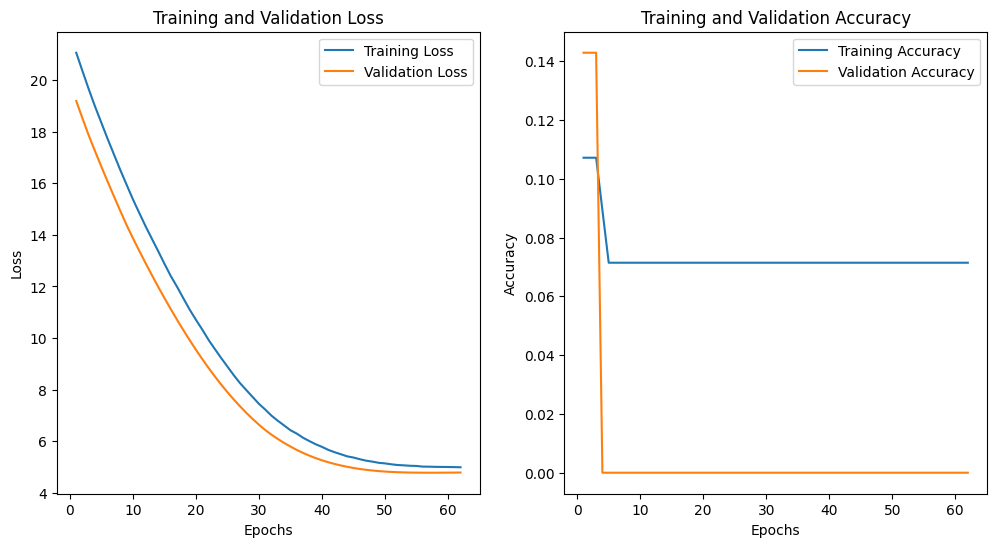

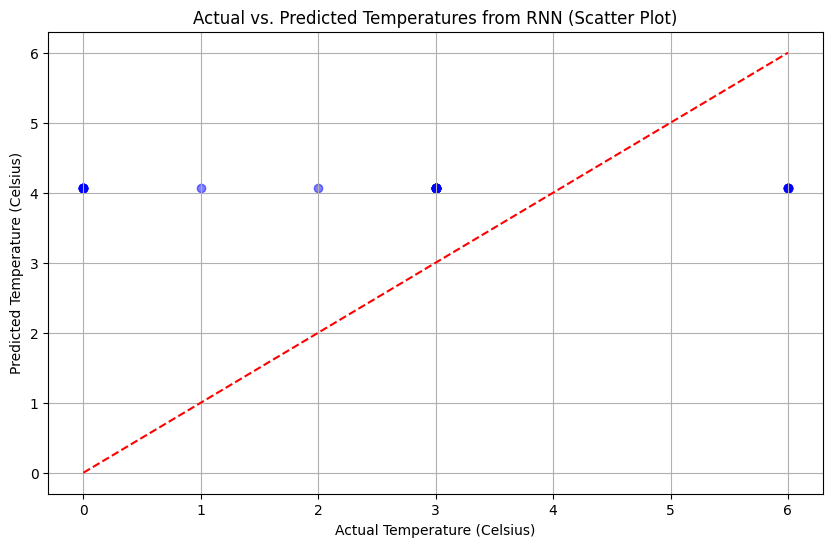

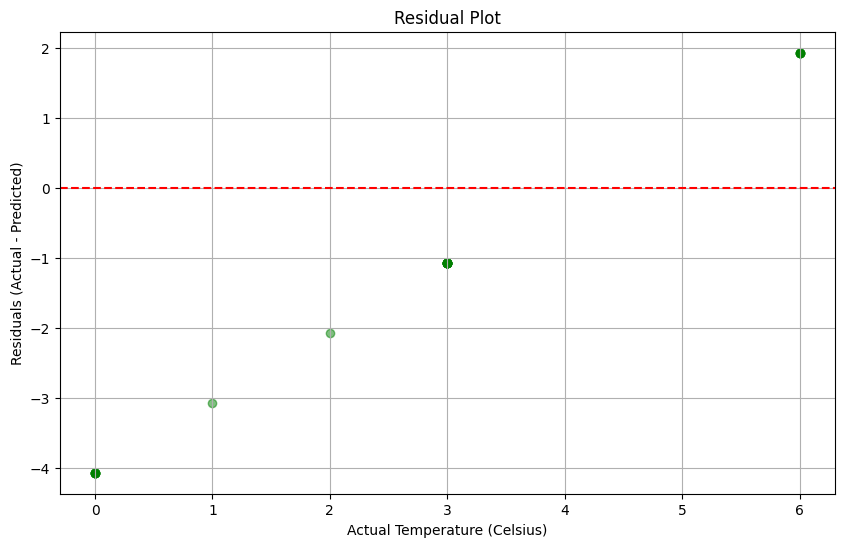

Baseline Mean Absolute Error (MAE): 1.8333333333333333
Baseline Root Mean Squared Error (RMSE): 2.183269719175042


In [27]:

# Plot the relation between losses and accuracy
plt.figure(figsize=(12, 6))
epochs = range(1, len(history.history['loss']) + 1)

plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Calculate actual and predicted temperatures for evaluation
actual_temperatures_rnn = y_test_rnn.flatten()
predicted_temperatures_rnn = rnn_model.predict(X_test_rnn).flatten()

# Calculate residuals
residuals = actual_temperatures_rnn - predicted_temperatures_rnn

# Visual Inspection: Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn,
            predicted_temperatures_rnn, color='blue', alpha=0.5)
plt.plot([min(actual_temperatures_rnn), max(actual_temperatures_rnn)], [min(actual_temperatures_rnn), max(
    actual_temperatures_rnn)], color='red', linestyle='--')  # Diagonal line for reference
plt.title('Actual vs. Predicted Temperatures from RNN (Scatter Plot)')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Predicted Temperature (Celsius)')
plt.grid(True)
plt.show()

# Error Analysis: Residual Plot
plt.figure(figsize=(10, 6))
plt.scatter(actual_temperatures_rnn, residuals, color='green', alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')  # Horizontal line at y=0
plt.title('Residual Plot')
plt.xlabel('Actual Temperature (Celsius)')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True)
plt.show()

# Model Comparison with Baseline
mean_temperature = np.mean(actual_temperatures_rnn)
baseline_predictions = np.full_like(actual_temperatures_rnn, mean_temperature)

baseline_mae = mean_absolute_error(
    actual_temperatures_rnn, baseline_predictions)
baseline_rmse = np.sqrt(mean_squared_error(
    actual_temperatures_rnn, baseline_predictions))

print(f"Baseline Mean Absolute Error (MAE): {baseline_mae}")
print(f"Baseline Root Mean Squared Error (RMSE): {baseline_rmse}")

In [28]:
import os

# Get the current working directory
current_directory = os.getcwd()
print("Current Directory:", current_directory)

# List all files and directories in the current directory
files_in_directory = os.listdir(current_directory)
print("Files in Directory:", files_in_directory)

Current Directory: /content
Files in Directory: ['.config', 'random_forest_weather_model.joblib', 'weather_forecast.csv', 'logistic_regression_weather_model.joblib', 'sample_data']
